<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Time-Series-Forecasting/blob/main/Notebooks/Part1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Project Detail

**Problem:** Time Series Forecasting

**Goal:** The task is to develop a forecasting model that is able to predict several uncorrelated time series. The prerequisite is that the model exhibits generalisation capabilities in the forecasting domain, allowing it to transcend the constraints of specific time domains. This requires a model that, while specialised in forecasting, is not limited to predicting in a single or predefined time context.

**Dataset Detail:**


1.   Time series length: the length of the time series in the training dataset is variable. To simplify the portability of the dataset, we padded with zeros the sequences to the maximum length of 2776. Thus, the dataset is provided in a compact form as a Nx2776 array. We provide an additional 'valid_periods.npy' file containing the information to recover the original time series without the padding
2.   File Format: npy

3.   Categories: the provided time series are composed by sequences collected from 6 different sources. We further provide additional information about the category of each time series.


**Datas Structure:** Single folder containing the following files:
1. 'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000 time series of length 2776.
2. 'valid_periods.npy': it contains a numpy array of type (48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding.
3. 'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.
`IMPORTANT:` This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set. To download `**datset**`, click on the link below: [link](https://drive.google.com/drive/folders/1LntbkzHK04CtRrXl8s9U62FH6V2VFkce?usp=sharing) and for `**github repositoy**` please click on this: [Link](https://github.com/Mohammad-Amirifard/Time-Series-Forecasting)

**Notebook 1:** In this notebook we are trying to do the first analyses on datas. Notebook 2 is dedicated for model choesed based on problem.

In [5]:
# Copy  Project to /content direcory. Please replace project_directory with yours.
# project_directory = "/content/drive/MyDrive/AN2DL"
project_directory = "./"
# %cp -r {project_directory} /content

###2- Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
%matplotlib inline

###3- Load data

In [7]:
categories = np.load(f'{project_directory}/training_dataset/categories.npy')
training_data = np.load(f'{project_directory}/training_dataset/training_data.npy')
valid_periods = np.load(f'{project_directory}/training_dataset/valid_periods.npy')

In [8]:
print(training_data.dtype)

training_data = training_data.astype(np.float16)

print(training_data.dtype)

float64
float16


### 4- EDA

####4-1 First info of Datasets

In [9]:
print(f'training_data.shape: {training_data.shape}')
print(f'categories.shape: {categories.shape}')
print(f'valid_periods.shape: {valid_periods.shape}')

training_data.shape: (48000, 2776)
categories.shape: (48000,)
valid_periods.shape: (48000, 2)


In [10]:
import pandas as pd

# Function to detect outliers in a time series based on IQR
def detect_outliers(series):
    Q1 = np.percentile(series, 25)
    Q3 = np.percentile(series, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((series < lower_bound) | (series > upper_bound))

# Applying the outlier detection function to each time series
outliers_indices = [detect_outliers(training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]) for i in range(len(training_data))]


# Counting the number of outliers in each time series
outliers_count = [len(outliers[0]) for outliers in outliers_indices]

# Creating a DataFrame for better visualization
outliers_df = pd.DataFrame({'Time Series': range(len(training_data)), 'Outliers Count': outliers_count})
outliers_df.head()


,Time Series,Outliers Count
0,0,8
1,1,2
2,2,0
3,3,0
4,4,0


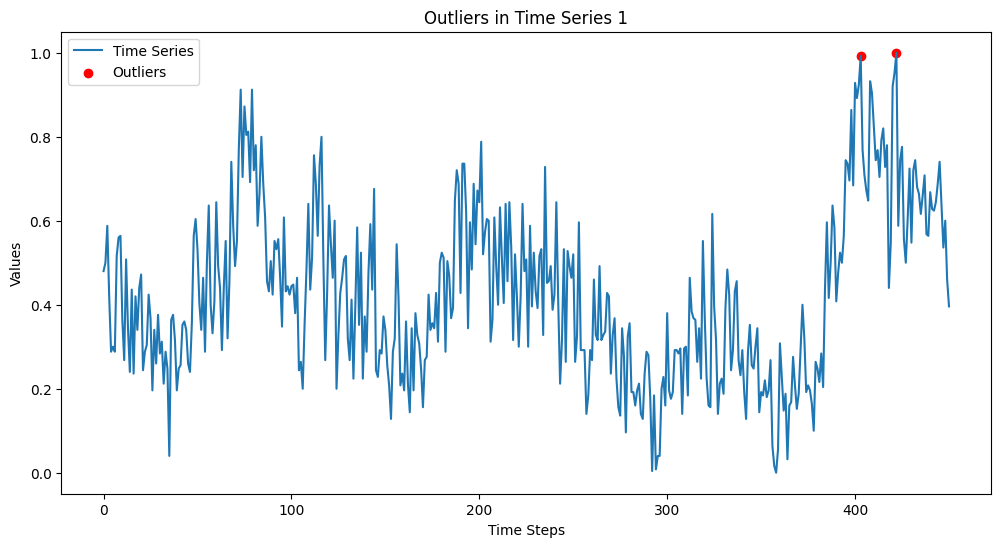

In [12]:
# Function to plot outliers for a given time series
def plot_outliers(time_series_index):
    series = training_data[time_series_index, valid_periods[time_series_index, 0]:valid_periods[time_series_index, 1]]
    outliers = outliers_indices[time_series_index]

    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Time Series')
    plt.scatter(outliers, series[outliers], color='red', label='Outliers')
    plt.title(f'Outliers in Time Series {time_series_index}')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

# Plotting outliers for the first time series as an example
plot_outliers(1)

In [13]:
from scipy.stats.mstats import winsorize

def winsorize_series(series, limits=[0.05, 0.05]):
    """
    Apply Winsorization to cap extreme values in the series.
    'limits' specifies the percentages of data to be replaced at both tails.
    """
    return winsorize(series, limits=limits)

winsorized_training_data = np.zeros_like(training_data)

# Example usage
for i in range(len(training_data)):
    valid_data = training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]
    winsorized_training_data[i, valid_periods[i, 0]:valid_periods[i, 1]] = winsorize_series(valid_data)


In [14]:
from sklearn.preprocessing import RobustScaler

def robust_scale_series(series):
    """
    Apply Robust Scaling to the series.
    The scaler removes the median and scales the data according to the IQR.
    """
    scaler = RobustScaler()
    return scaler.fit_transform(series.reshape(-1, 1)).flatten()

scaled_training_data = np.zeros_like(training_data)

# Example usage
for i in range(len(training_data)):
    valid_data = training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]
    scaled_training_data[i, valid_periods[i, 0]:valid_periods[i, 1]] = robust_scale_series(valid_data)


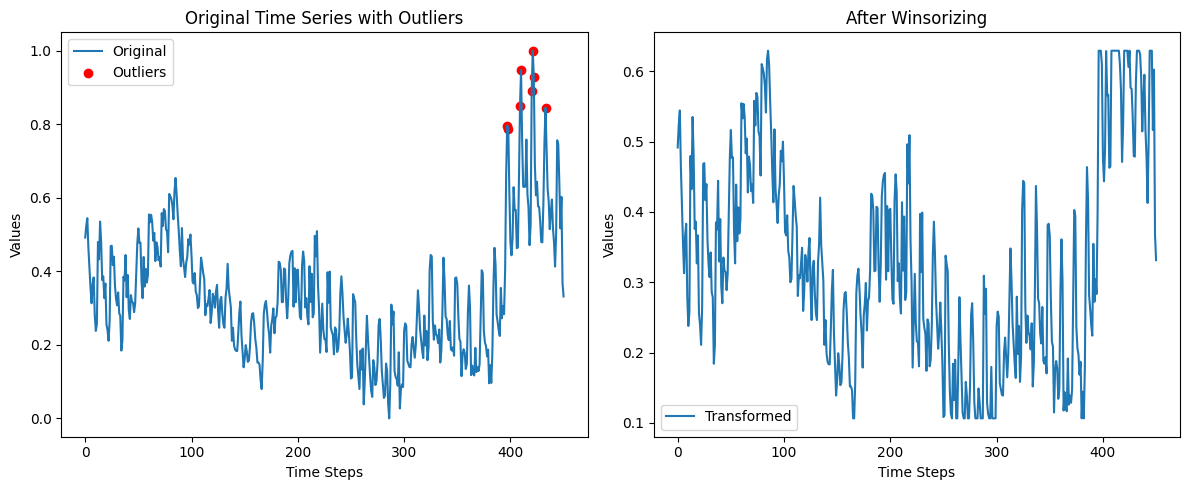

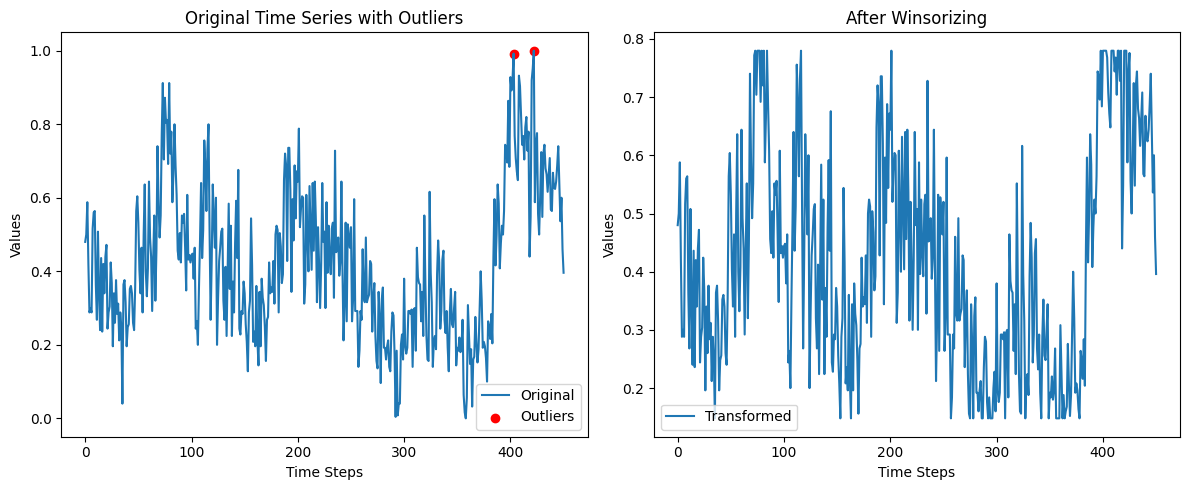

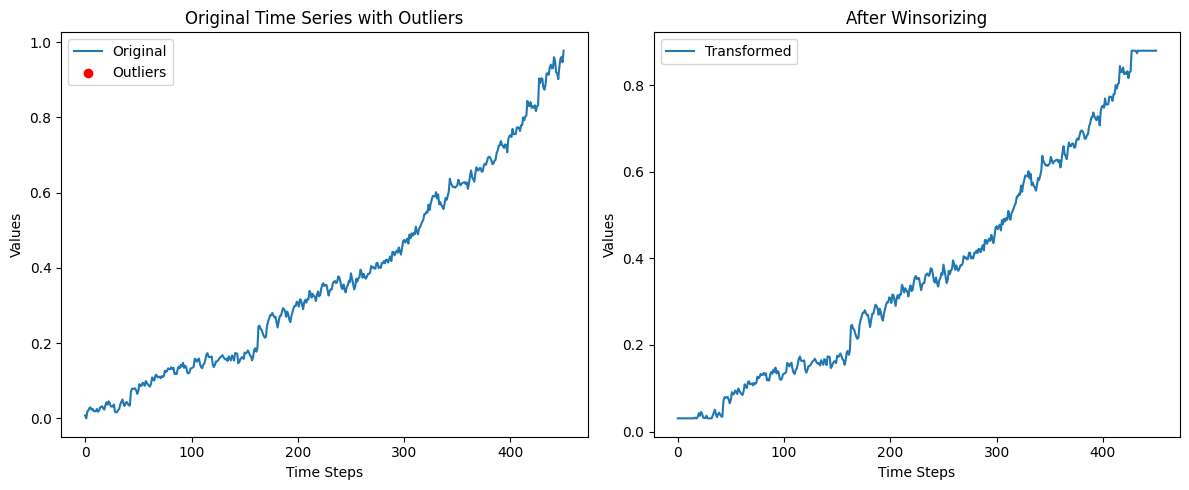

In [15]:
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import RobustScaler

# def detect_outliers(series):
#     Q1 = np.percentile(series, 25)
#     Q3 = np.percentile(series, 75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return np.where((series < lower_bound) | (series > upper_bound))

def robust_scale_series(series):
    scaler = RobustScaler()
    return scaler.fit_transform(series.reshape(-1, 1)).flatten()

def winsorize_series(series, limits=[0.05, 0.05]):
    return winsorize(series, limits=limits)

def plot_series_before_after(series, method='robust'):
    plt.figure(figsize=(12, 5))

    # Original series with outliers
    plt.subplot(1, 2, 1)
    plt.plot(series, label='Original')
    outliers = detect_outliers(series)
    plt.scatter(outliers, series[outliers], color='red', label='Outliers')
    plt.title('Original Time Series with Outliers')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()

    # Series after transformation
    plt.subplot(1, 2, 2)
    if method == 'robust':
        transformed_series = robust_scale_series(series)
        plt.title('After Robust Scaling')
    elif method == 'winsorize':
        transformed_series = winsorize_series(series)
        plt.title('After Winsorizing')
    
    plt.plot(transformed_series, label='Transformed')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example: Plotting for the first few time series
for i in range(3):
    series = training_data[i, valid_periods[i, 0]:valid_periods[i, 1]]
    plot_series_before_after(series, method='winsorize')  # Change to 'winsorize' or 'robust' if needed


In [16]:
# To get information about the "most common" sequence length, we'll calculate the lengths of the valid sequences
# and then analyze these lengths to find the most common one.

valid_lengths = valid_periods[:, 1] - valid_periods[:, 0]  # Calculate lengths of valid periods
unique_lengths, counts = np.unique(valid_lengths, return_counts=True)  # Get unique lengths and their counts

# Find the most common length
most_common_length = unique_lengths[np.argmax(counts)]
most_common_count = counts[np.argmax(counts)]

# Calculate some basic statistics
average_length = np.mean(valid_lengths)
median_length = np.median(valid_lengths)
min_length = np.min(valid_lengths)
max_length = np.max(valid_lengths)

most_common_length, most_common_count, average_length, median_length, min_length, max_length

(51, 6703, 198.30022916666667, 184.0, 24, 2776)

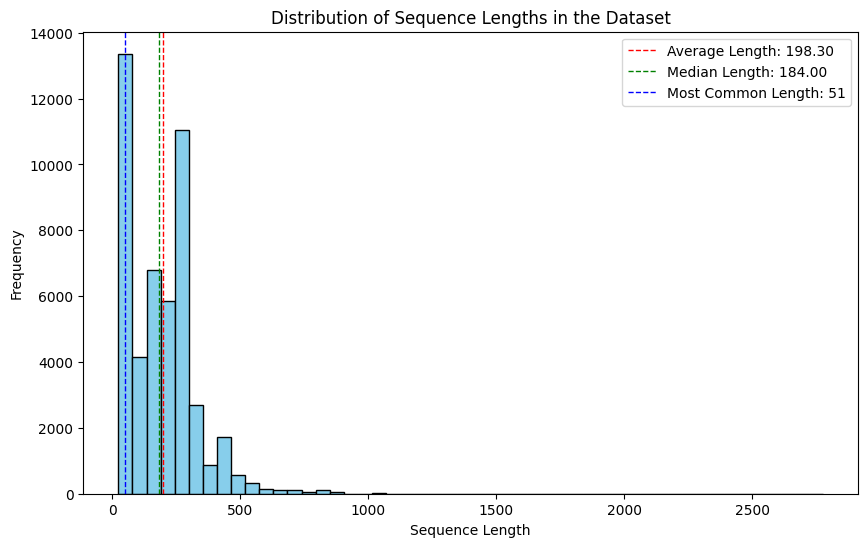

In [17]:
# Plotting the distribution of sequence lengths

plt.figure(figsize=(10, 6))
plt.hist(valid_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sequence Lengths in the Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(average_length, color='r', linestyle='dashed', linewidth=1, label=f'Average Length: {average_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median Length: {median_length:.2f}')
plt.axvline(most_common_length, color='b', linestyle='dashed', linewidth=1, label=f'Most Common Length: {most_common_length}')
plt.legend()
plt.show()



In [18]:
#this never skips anytging even if smaller than our window 
def create_windows(data, lookback, lookahead,stride, valid_periods, padding_strategy='zero'):
    windows = []
    labels = []
    for idx, series in enumerate(data):
        
        start, end = valid_periods[idx]
        series_length = end - start

        # Series longer than lookback
        if series_length >= lookback:
            for i in range(start, end - lookback - lookahead + 1, stride):
                windows.append(series[i:i+lookback])
                labels.append(series[i+lookback:i+lookback+lookahead])
        else:
            # Padding the input window
            if series_length > 0:
                if padding_strategy == 'zero':
                    padded_series = np.pad(series[start:end], (lookback - series_length, 0), 'constant')
                elif padding_strategy == 'repeat':
                    padded_series = np.pad(series[start:end], (lookback - series_length, 0), 'edge')
                windows.append(padded_series)
            else:
                # If series is empty, create a window of zeros
                windows.append(np.zeros(lookback))

            # Creating labels for short series
            if series_length >= lookahead:
                labels.append(series[end-lookahead:end])
            else:
                # Padding or repeating for missing lookahead steps
                missing_steps = lookahead - series_length
                if series_length > 0:
                    last_value = series[end-1]
                    padded_label = np.append(series[start:end], [last_value]*missing_steps)
                else:
                    # If series is empty, create a label of zeros
                    padded_label = np.zeros(lookahead)
                labels.append(padded_label)

    return np.array(windows), np.array(labels)

In [19]:
lookback = 200
lookahead = 9
stride = 5
input_data_2d, labels_2d = create_windows(training_data, lookback, lookahead, stride, valid_periods, padding_strategy='zero')

In [21]:
# Assuming all_input_windows is a 2D array of shape [number_of_windows, window_size]
# Reshape to 3D for LSTM [samples, timesteps, features]

input_data_3d = input_data_2d.reshape((input_data_2d.shape[0], input_data_2d.shape[1], 1))

# Now, all_input_windows_3d is of shape [number_of_windows, window_size, 1]
# Assuming all_output_windows is initially 2D of shape [number_of_samples, lookahead]
# Reshape to 3D for LSTM output [samples, timesteps, features]

labels_3d = labels_2d.reshape((labels_2d.shape[0], labels_2d.shape[1], 1))

# Now, all_output_windows_3d is of shape [number_of_samples, lookahead, 1]

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint

# Assuming your data has these dimensions
num_features = 1  # Number of features in each time step (e.g., univariate = 1)

model = Sequential()
# Masking layer to ignore the padded zeros (assuming 0 is your padding value)
model.add(Masking(mask_value=0., input_shape=(lookback, num_features)))
# LSTM layer
model.add(LSTM(units=50, return_sequences=False))  # Adjust 'units' as needed
# Output layer - adjust the units based on your forecasting needs
model.add(Dense(units=9))  # '9' for 9 time steps ahead prediction try to set it to 1
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Choose an optimizer and loss function appropriate for your problem

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

model_checkpoint = ModelCheckpoint(
    'best_model',  # Directory name to save the model
    monitor='val_loss', 
    mode='min', 
    save_best_only=True, 
    save_format='tf',  # Save the model in TensorFlow SavedModel format
    verbose=1
)

# Assuming 'windows' as your input data and 'labels' as your target data
history = model.fit(
    input_data_3d, labels_3d,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[model_checkpoint,early_stopping],
    verbose=1
)
model.summary()

Epoch 1/20
    7/66672 [..............................] - ETA: 590:47:07 - loss: 0.2972

KeyboardInterrupt: 

In [ ]:
model.save('my_model')  # This will create a folder 'my_model'


In [ ]:
self.model = tf.keras.models.load_model('SubmissionModel')